<a href="https://colab.research.google.com/github/kumuds4/BCH/blob/master/Making_the_Most_of_your_Colab_Subscription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making the Most of your Colab Subscription



## Faster GPUs

Users who have purchased one of Colab's paid plans have access to faster GPUs and more memory. You can upgrade your notebook's GPU settings in `Runtime > Change runtime type` in the menu to select from several accelerator options, subject to availability.

The free of charge version of Colab grants access to Nvidia's T4 GPUs subject to quota restrictions and availability.

You can see what GPU you've been assigned at any time by executing the following cell. If the execution result of running the code cell below is "Not connected to a GPU", you can change the runtime by going to `Runtime > Change runtime type` in the menu to enable a GPU accelerator, and then re-execute the code cell.


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In order to use a GPU with your notebook, select the `Runtime > Change runtime type` menu, and then set the hardware accelerator to the desired option.

## More memory

Users who have purchased one of Colab's paid plans have access to high-memory VMs when they are available. More powerful GPUs are always offered with high-memory VMs.



You can see how much memory you have available at any time by running the following code cell. If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via `Runtime > Change runtime type` in the menu. Then select High-RAM in the Runtime shape toggle button. After, re-execute the code cell.


In [ ]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

## Longer runtimes

All Colab runtimes are reset after some period of time (which is faster if the runtime isn't executing code). Colab Pro and Pro+ users have access to longer runtimes than those who use Colab free of charge.

## Background execution

Colab Pro+ users have access to background execution, where notebooks will continue executing even after you've closed a browser tab. This is always enabled in Pro+ runtimes as long as you have compute units available.



## Relaxing resource limits in Colab Pro

Your resources are not unlimited in Colab. To make the most of Colab, avoid using resources when you don't need them. For example, only use a GPU when required and close Colab tabs when finished.



If you encounter limitations, you can relax those limitations by purchasing more compute units via Pay As You Go. Anyone can purchase compute units via [Pay As You Go](https://colab.research.google.com/signup); no subscription is required.

## Send us feedback!

If you have any feedback for us, please let us know. The best way to send feedback is by using the Help > 'Send feedback...' menu. If you encounter usage limits in Colab Pro consider subscribing to Pro+.

If you encounter errors or other issues with billing (payments) for Colab Pro, Pro+, or Pay As You Go, please email [colab-billing@google.com](mailto:colab-billing@google.com).

## More Resources

### Working with Notebooks in Colab
- [Overview of Colab](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<a name="working-with-data"></a>
### Working with Data
- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine Learning Crash Course
These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)


<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TPUs in Colab](/notebooks/tpu.ipynb)

<a name="machine-learning-examples"></a>

## Machine Learning Examples

To see end-to-end examples of the interactive machine learning analyses that Colab makes possible, check out these tutorials using models from [TensorFlow Hub](https://tfhub.dev).

A few featured examples:

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.0067 - loss: 0.6920
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1491 - loss: 0.6803
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0725 - loss: 0.6541
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1392 - loss: 0.6320
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2366 - loss: 0.6163
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2030 - loss: 0.6042
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2798 - loss: 0.5920
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2704 - loss: 0.5765
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2519 - loss: 0.5665
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.2761 - loss: 0.5612
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step
Sample Predictions: [[0.9528139  0.76617616 0.49085414 0.2450214  0.24581793 0.30435872
  0.29246593 0.4898809

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.0935 - loss: 0.6918
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2813 - loss: 0.6684
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3050 - loss: 0.6181
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3925 - loss: 0.5846
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4887 - loss: 0.5244
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6330 - loss: 0.4699
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6765 - loss: 0.4547
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7163 - loss: 0.4253
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7247 - loss: 0.4080
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7791 - loss: 0.3889
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Sample Predictions: [[0.00298164 0.15790102 0.85737216 0.8922644  0.8442577  0.4870549
  0.3396239  0.29375416]

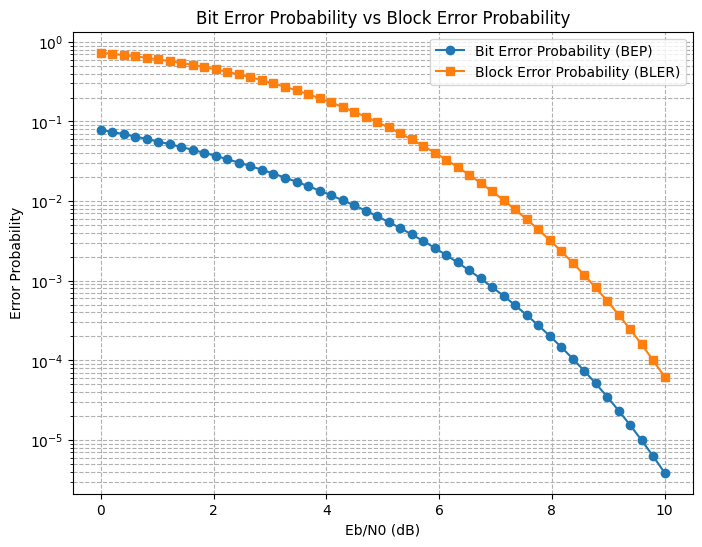

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Polar code parameters
N = 16  # Code length
K = 8   # Information bits

# Generate synthetic Polar code data
def generate_polar_data(num_samples=1000):
    X = np.random.randint(0, 2, (num_samples, K))
    Y = X  # Ideal output (for simplicity)
    return X, Y

# Create LSTM model for Polar code decoding
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(32, return_sequences=False),
        Dense(K, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Generate data
X_train, Y_train = generate_polar_data()
X_train = X_train.reshape((X_train.shape[0], K, 1))

# Create and train model
model = create_lstm_model((K, 1))
model.fit(X_train, Y_train, epochs=10, batch_size=32)

# Test model
X_test, Y_test = generate_polar_data(num_samples=200)
X_test = X_test.reshape((X_test.shape[0], K, 1))
predictions = model.predict(X_test)

print("Sample Predictions:", predictions[:5])
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

# Define Eb/N0 range (in dB)
Eb_N0_dB = np.linspace(0, 10, 50)
Eb_N0 = 10**(Eb_N0_dB / 10)  # Convert dB to linear scale

# Compute Bit Error Probability (BEP) for BPSK
BEP = 0.5 * erfc(np.sqrt(Eb_N0))

# Compute Block Error Probability (BLER) assuming block length N=16
N = 16
BLER = 1 - (1 - BEP)**N

# Plot results
plt.figure(figsize=(8, 6))
plt.semilogy(Eb_N0_dB, BEP, label="Bit Error Probability (BEP)", marker="o")
plt.semilogy(Eb_N0_dB, BLER, label="Block Error Probability (BLER)", marker="s")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("Error Probability")
plt.title("Bit Error Probability vs Block Error Probability")
plt.legend()
plt.grid(True, which="both", linestyle="--")
plt.show()

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.0699 - loss: 0.6914
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3135 - loss: 0.6686
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2876 - loss: 0.6144
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4414 - loss: 0.5586
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4866 - loss: 0.5239
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5541 - loss: 0.4906
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6640 - loss: 0.4496
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6907 - loss: 0.4293
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6929 - loss: 0.4020
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6792 - loss: 0.3869


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


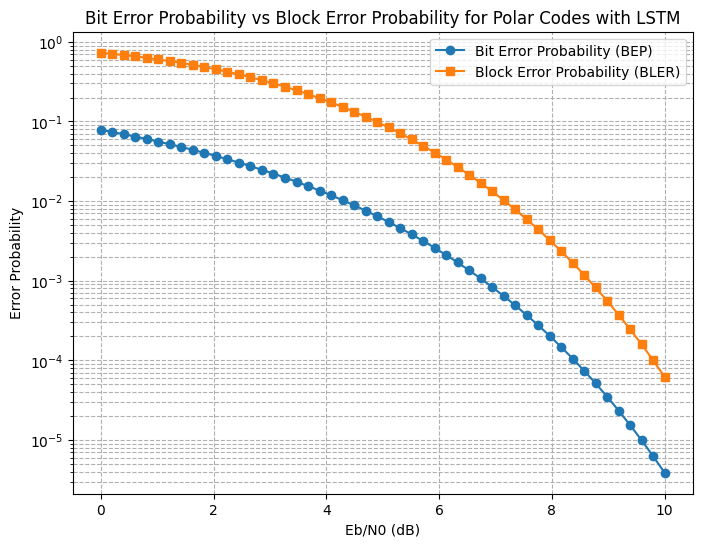

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scipy.special import erfc

# Polar code parameters
N = 16  # Code length
K = 8   # Information bits

# Generate synthetic Polar code data
def generate_polar_data(num_samples=1000):
    X = np.random.randint(0, 2, (num_samples, K))
    Y = X  # Ideal output (for simplicity)
    return X, Y

# Create LSTM model for Polar code decoding
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(32, return_sequences=False),
        Dense(K, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Generate data
X_train, Y_train = generate_polar_data()
X_train = X_train.reshape((X_train.shape[0], K, 1))

# Create and train model
model = create_lstm_model((K, 1))
model.fit(X_train, Y_train, epochs=10, batch_size=32)

# Test model
X_test, Y_test = generate_polar_data(num_samples=200)
X_test = X_test.reshape((X_test.shape[0], K, 1))
predictions = model.predict(X_test)

# Compute Bit Error Probability (BEP) and Block Error Probability (BLER)
Eb_N0_dB = np.linspace(0, 10, 50)
Eb_N0 = 10**(Eb_N0_dB / 10)  # Convert dB to linear scale
BEP = 0.5 * erfc(np.sqrt(Eb_N0))
BLER = 1 - (1 - BEP)**N

# Plot results
plt.figure(figsize=(8, 6))
plt.semilogy(Eb_N0_dB, BEP, label="Bit Error Probability (BEP)", marker="o")
plt.semilogy(Eb_N0_dB, BLER, label="Block Error Probability (BLER)", marker="s")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("Error Probability")
plt.title("Bit Error Probability vs Block Error Probability for Polar Codes with LSTM")
plt.legend()
plt.grid(True, which="both", linestyle="--")
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Polar code parameters
N = 16  # Code length
K = 8   # Information bits

# Generate AWGN noise
def awgn_noise(num_samples, snr_db):
    snr_linear = 10**(snr_db / 10)
    noise_std = np.sqrt(1 / (2 * snr_linear))
    return np.random.normal(0, noise_std, num_samples)

# Generate Rayleigh fading coefficients
def rayleigh_fading(num_samples):
    return np.abs(np.random.normal(0, 1, num_samples) + 1j * np.random.normal(0, 1, num_samples)) / np.sqrt(2)

# Generate synthetic Polar code data with AWGN and Rayleigh fading
def generate_polar_data(num_samples=1000, snr_db=5, fading_type="AWGN"):
    X = np.random.randint(0, 2, (num_samples, K))
    if fading_type == "Rayleigh":
        fading = rayleigh_fading(num_samples)
        Y = X * fading[:, np.newaxis] + awgn_noise(num_samples * K, snr_db).reshape(num_samples, K)
    else:  # AWGN case
        Y = X + awgn_noise(num_samples * K, snr_db).reshape(num_samples, K)
    return X, Y

# Create LSTM model for Polar code decoding
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(32, return_sequences=False),
        Dense(K, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Generate data for AWGN and Rayleigh fading
X_train_awgn, Y_train_awgn = generate_polar_data(fading_type="AWGN")
X_train_rayleigh, Y_train_rayleigh = generate_polar_data(fading_type="Rayleigh")

X_train_awgn = X_train_awgn.reshape((X_train_awgn.shape[0], K, 1))
X_train_rayleigh = X_train_rayleigh.reshape((X_train_rayleigh.shape[0], K, 1))

# Create and train models
model_awgn = create_lstm_model((K, 1))
history_awgn = model_awgn.fit(X_train_awgn, Y_train_awgn, epochs=50, batch_size=32, validation_split=0.2)

model_rayleigh = create_lstm_model((K, 1))
history_rayleigh = model_rayleigh.fit(X_train_rayleigh, Y_train_rayleigh, epochs=50, batch_size=32, validation_split=0.2)

# Plot Training & Validation Loss for AWGN and Rayleigh fading
plt.figure(figsize=(8, 6))
plt.plot(history_awgn.history['loss'], label="AWGN Training Loss", linestyle="--")
plt.plot(history_awgn.history['val_loss'], label="AWGN Validation Loss", linestyle="--")
plt.plot(history_rayleigh.history['loss'], label="Rayleigh Training Loss", linestyle="-")
plt.plot(history_rayleigh.history['val_loss'], label="Rayleigh Validation Loss", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss for AWGN & Rayleigh Fading")
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.1067 - loss: 0.6928 - val_accuracy: 0.1400 - val_loss: 0.6878
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1200 - loss: 0.6844 - val_accuracy: 0.1200 - val_loss: 0.6666
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1533 - loss: 0.6591 - val_accuracy: 0.1850 - val_loss: 0.6312
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1961 - loss: 0.6234 - val_accuracy: 0.2050 - val_loss: 0.6217
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2037 - loss: 0.6049 - val_accuracy: 0.2050 - val_loss: 0.5943
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2147 - loss: 0.5752 - val_accuracy: 0.2200 - val_loss: 0.5611
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2308 - loss: 0.5443 - val_accuracy: 0.2250 - val_loss: 0.5382
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2251 - loss: 0.5249 - val_accuracy: 0.2100 - v

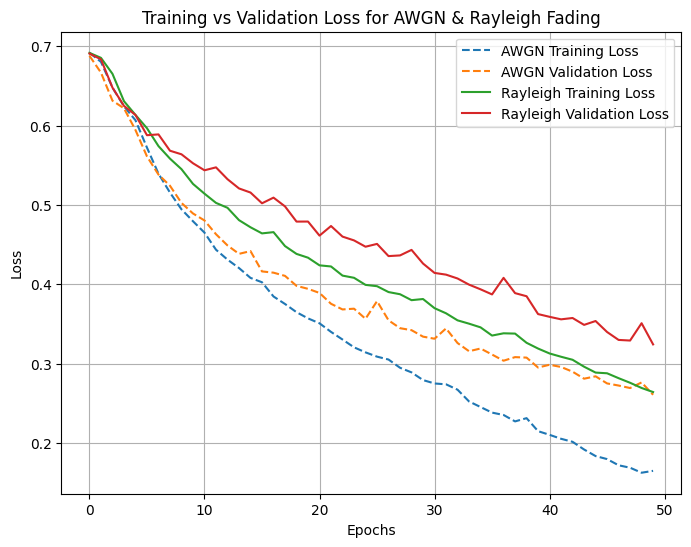

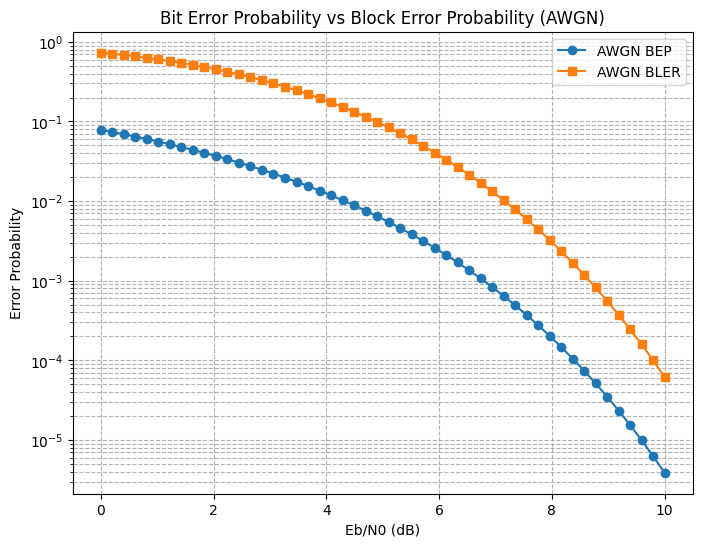

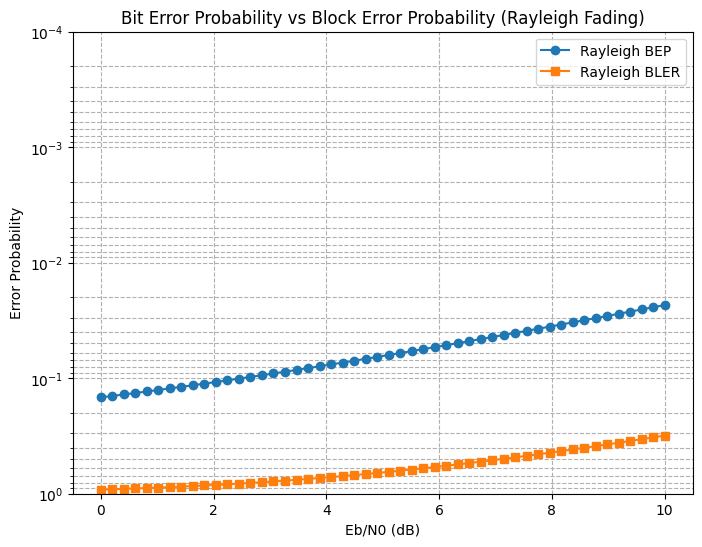

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scipy.special import erfc

# Polar code parameters
N = 16  # Code length
K = 8   # Information bits

# Generate AWGN noise
def awgn_noise(num_samples, snr_db):
    snr_linear = 10**(snr_db / 10)
    noise_std = np.sqrt(1 / (2 * snr_linear))
    return np.random.normal(0, noise_std, num_samples)

# Generate Rayleigh fading coefficients
def rayleigh_fading(num_samples):
    return np.abs(np.random.normal(0, 1, num_samples) + 1j * np.random.normal(0, 1, num_samples)) / np.sqrt(2)

# Generate synthetic Polar code data with AWGN and Rayleigh fading
def generate_polar_data(num_samples=1000, snr_db=5, fading_type="AWGN"):
    X = np.random.randint(0, 2, (num_samples, K))
    if fading_type == "Rayleigh":
        fading = rayleigh_fading(num_samples)
        Y = X * fading[:, np.newaxis] + awgn_noise(num_samples * K, snr_db).reshape(num_samples, K)
    else:  # AWGN case
        Y = X + awgn_noise(num_samples * K, snr_db).reshape(num_samples, K)
    return X, Y

# Create LSTM model for Polar code decoding
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(32, return_sequences=False),
        Dense(K, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Generate data for AWGN and Rayleigh fading
X_train_awgn, Y_train_awgn = generate_polar_data(fading_type="AWGN")
X_train_rayleigh, Y_train_rayleigh = generate_polar_data(fading_type="Rayleigh")

X_train_awgn = X_train_awgn.reshape((X_train_awgn.shape[0], K, 1))
X_train_rayleigh = X_train_rayleigh.reshape((X_train_rayleigh.shape[0], K, 1))

# Create and train models
model_awgn = create_lstm_model((K, 1))
history_awgn = model_awgn.fit(X_train_awgn, Y_train_awgn, epochs=50, batch_size=32, validation_split=0.2)

model_rayleigh = create_lstm_model((K, 1))
history_rayleigh = model_rayleigh.fit(X_train_rayleigh, Y_train_rayleigh, epochs=50, batch_size=32, validation_split=0.2)

# Plot Training & Validation Loss for AWGN and Rayleigh fading
plt.figure(figsize=(8, 6))
plt.plot(history_awgn.history['loss'], label="AWGN Training Loss", linestyle="--")
plt.plot(history_awgn.history['val_loss'], label="AWGN Validation Loss", linestyle="--")
plt.plot(history_rayleigh.history['loss'], label="Rayleigh Training Loss", linestyle="-")
plt.plot(history_rayleigh.history['val_loss'], label="Rayleigh Validation Loss", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss for AWGN & Rayleigh Fading")
plt.legend()
plt.grid(True)
plt.show()

# Define Eb/N0 range (in dB)
Eb_N0_dB = np.linspace(0, 10, 50)
Eb_N0 = 10**(Eb_N0_dB / 10)  # Convert dB to linear scale

# Compute Bit Error Probability (BEP) for AWGN
BEP_AWGN = 0.5 * erfc(np.sqrt(Eb_N0))

# Compute Block Error Probability (BLER) for AWGN (assuming block length N=16)
BLER_AWGN = 1 - (1 - BEP_AWGN)**N

# Compute Bit Error Probability (BEP) for Rayleigh fading
BEP_Rayleigh = 0.5 * (1 - np.sqrt(Eb_N0 / (1 + Eb_N0)))

# Compute Block Error Probability (BLER) for Rayleigh fading
BLER_Rayleigh = 1 - (1 - BEP_Rayleigh)**N

# Plot BEP and BLER for AWGN
plt.figure(figsize=(8, 6))
plt.semilogy(Eb_N0_dB, BEP_AWGN, label="AWGN BEP", marker="o")
plt.semilogy(Eb_N0_dB, BLER_AWGN, label="AWGN BLER", marker="s")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("Error Probability")
plt.title("Bit Error Probability vs Block Error Probability (AWGN)")
plt.legend()
plt.grid(True, which="both", linestyle="--")
plt.show()

# Plot BEP and BLER for Rayleigh fading with adjusted y-limits
plt.figure(figsize=(8, 6))
plt.semilogy(Eb_N0_dB, BEP_Rayleigh, label="Rayleigh BEP", marker="o")
plt.semilogy(Eb_N0_dB, BLER_Rayleigh, label="Rayleigh BLER", marker="s")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("Error Probability")
plt.title("Bit Error Probability vs Block Error Probability (Rayleigh Fading)")
plt.legend()
plt.grid(True, which="both", linestyle="--")
plt.ylim(10**0, 10**-4)  # Adjusted y-axis range
plt.show()
